# Definitions twisstntern_simulate

In [2]:
import msprime
import numpy as np
import scipy
from IPython.display import SVG
import tskit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The function twisstntern_simulate_demography creates demography and implements options below.
For command line implementation should be combined with simulation part in corresponding mode.

###########################################
# CONFIGURATION FILE FOR MSPRIME SIMULATION
###########################################

###########################################
STEP 1: Setting up demography
# Four-population demographic model
# NOTE: all simulations are haploid
# You can modify the values below or leave them as defaults

#=== SPLIT TIMES (in generations before present) ===#
# These define the timing of historical splits between populations.
# Larger values indicate older divergence events.

t1 = 100     # default 100 — Split between p1 and p2 (ancestor: p12)
t2 = 200     # default 200 — Split between p12 and p3 (ancestor: p123)
t3 = 300     # default 300 — Split between p123 and outgroup O

#=== EFFECTIVE POPULATION SIZES (diploid individuals) ===#
# Ne values for each extant and ancestral population.
# Affects genetic drift and coalescent times.

ne_p1 = 10000      # default 10000 — Extant population 1
ne_p2 = 10000      # default 10000 — Extant population 2
ne_p3 = 10000      # default 10000 — Extant population 3
ne_p12 = 10000     # default 10000 — Ancestor of p1 and p2
ne_p123 = 10000    # default 10000 — Ancestor of p1, p2, and p3
ne_O = 10000       # default 10000 — Outgroup population

#=== MIGRATION RATES (per generation) ===#
# These rates are proportions: e.g. 0.001 means 0.1% of individuals replaced by migrants per generation.
# Define direction as "source > destination" (note that msprime defines in the reverse order)
# Default m = 0.0

# Migration between extant populations
m_p1>p2 = 0.0      # default 0.0
m_p2>p1 = 0.0      # default 0.0
m_p1>p3 = 0.0      # default 0.0
m_p3>p1 = 0.0      # default 0.0
m_p2>p3 = 0.0      # default 0.0
m_p3>p2 = 0.0      # default 0.0

# Migration between outgroup and extant populations
m_O>p1 = 0.0       # default 0.0
m_p1>O = 0.0       # default 0.0
m_O>p2 = 0.0       # default 0.0
m_p2>O = 0.0       # default 0.0
m_O>p3 = 0.0       # default 0.0
m_p3>O = 0.0       # default 0.0

# Migration involving ancestral populations
m_p12>p3 = 0.0     # default 0.0
m_p3>p12 = 0.0     # default 0.0
m_O>p123 = 0.0     # default 0.0
m_p123>O = 0.0     # default 0.0

In [4]:
def twisstntern_simulate_demography(
    t1=100, t2=200, t3=300,
    ne_p1=1e4, ne_p2=1e4, ne_p3=1e4, ne_p12=1e4, ne_p123=1e4, ne_0=1e4,
    m_p1_p2=0.0, m_p2_p1=0.0,
    m_p1_p3=0.0, m_p3_p1=0.0,
    m_p2_p3=0.0, m_p3_p2=0.0,
    m_O_p1=0.0, m_p1_O=0.0,
    m_O_p2=0.0, m_p2_O=0.0,
    m_O_p3=0.0, m_p3_O=0.0,
    m_p12_p3=0.0, m_p3_p12=0.0,
    m_O_p123=0.0, m_p123_O=0.0
):
    import msprime

    demography = msprime.Demography()

    # Add all populations
    for name, size in [
        ("P1", ne_p1), ("P2", ne_p2), ("P3", ne_p3), ("O", ne_0),
        ("P12", ne_p12), ("P123", ne_p123), ("ANC", ne_0)
    ]:
        demography.add_population(name=name, initial_size=size)

    # Population splits
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")

    # Unified list of population names
    pop_names = ["P1", "P2", "P3", "O", "P12", "P123"]

    # Full 6x6 migration matrix
    migration_matrix = [
        # P1       P2       P3      O       P12        P123
        [0.0,   m_p1_p2, m_p1_p3, m_p1_O,   0.0,       0.0],      # P1
        [m_p2_p1, 0.0,   m_p2_p3, m_p2_O,   0.0,       0.0],      # P2
        [m_p3_p1, m_p3_p2, 0.0,   m_p3_O,   m_p3_p12,  0.0],      # P3
        [m_O_p1,  m_O_p2, m_O_p3, 0.0,      0.0,       m_O_p123],# O
        [0.0,     0.0,    m_p12_p3, 0.0,    0.0,       0.0],      # P12
        [0.0,     0.0,    0.0,      m_p123_O, 0.0,     0.0]       # P123
    ]

    # Apply all pairwise migration rates using set_migration_rate
    for i, source in enumerate(pop_names):
        for j, dest in enumerate(pop_names):
            if i != j:
                rate = migration_matrix[i][j]
                demography.set_migration_rate(source=source, dest=dest, rate=rate)

    return demography


In [5]:
# Testing function twisstntern_simulate_demography

t1 = 100     # default 100 — Split between p1 and p2 (ancestor: p12)
t2 = 200     # default 200 — Split between p12 and p3 (ancestor: p123)
t3 = 300     # default 300 — Split between p123 and outgroup O

#=== EFFECTIVE POPULATION SIZES (diploid individuals) ===#
# Ne values for each extant and ancestral population.
# Affects genetic drift and coalescent times.

ne_p1 = 10000      # default 10000 — Extant population 1
ne_p2 = 10000      # default 10000 — Extant population 2
ne_p3 = 10000      # default 10000 — Extant population 3
ne_p12 = 10000     # default 10000 — Ancestor of p1 and p2
ne_p123 = 10000    # default 10000 — Ancestor of p1, p2, and p3
ne_O = 10000       # default 10000 — Outgroup population

#=== MIGRATION RATES (per generation) ===#
# These rates are proportions: e.g. 0.001 means 0.1% of individuals replaced by migrants per generation.
# Define direction as "source > destination" (note that msprime defines in the reverse order)
# Default m = 0.0

# Migration between extant populations
m_p1_p2 = 0.0      # default 0.0
m_p2_p1 = 0.0      # default 0.0
m_p1_p3 = 0.0      # default 0.0
m_p3_p1 = 0.0      # default 0.0
m_p2_p3 = 0.0      # default 0.0
m_p3_p2 = 0.0      # default 0.0

# Migration between outgroup and extant populations
m_O_p1 = 0.0       # default 0.0
m_p1_O = 0.0       # default 0.0
m_O_p2 = 0.0       # default 0.0
m_p2_O = 0.0       # default 0.0
m_O_p3 = 0.0       # default 0.0
m_p3_O = 0.0       # default 0.0

# Migration involving ancestral populations
m_p12_p3 = 0.0     # default 0.0
m_p3_p12 = 0.0     # default 0.0
m_O_p123 = 0.0     # default 0.0
m_p123_O = 0.0     # default 0.0



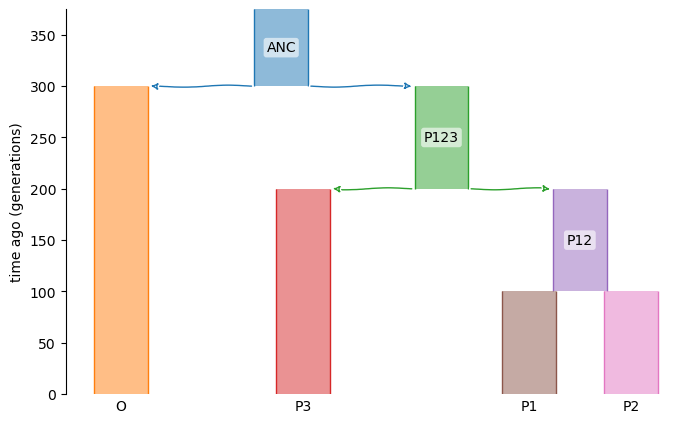

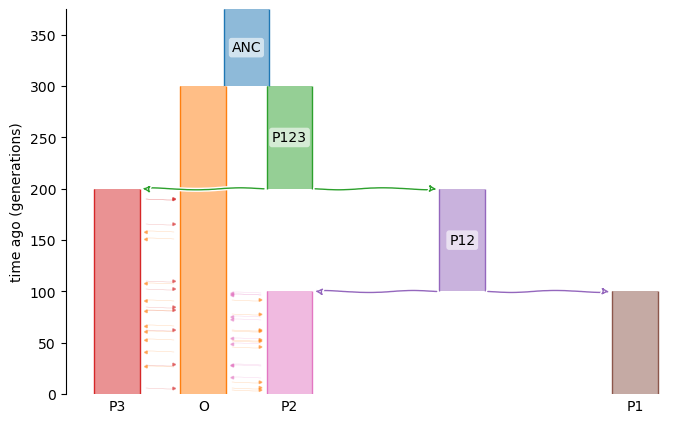

In [14]:

import demesdraw 

demography_nomig=twisstntern_simulate_demography()

# Visualize the demography
graph = demography_nomig.to_demes()
fig, ax = plt.subplots(figsize=(8.0, 5.0))
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

demography_mig=twisstntern_simulate_demography(m_O_p2=0.3, m_p2_O=0.01,
    m_O_p3=0.2, m_p3_O=0.1)

# Visualize the demography
graph = demography_mig.to_demes()
fig, ax = plt.subplots(figsize=(8.0, 5.0))
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

# NOTE: demesdraw can't handle migration in earlier brunches combines with one of terminal ones



The function twisstntern_simulate_locus takes demography and simulates in "locus" mode 
For command line implementation should be combined with demography part in corresponding mode.

###########################################
STEP 2: Coalescent simulation
n_ind =  . Number of haploid individuals to include (default 20 per popuation)
[optional: mutation rate]
[optional: random seed]
[optional: give meaningful names to four populations]

#=== Simulation mode "locus" ===#
#msprime will simualte independent non-recombining loci with length 10k
n_loci =  . Number of loci / windows to simulate  (default 10000)

In [ ]:
def twisstntern_simulate_locus(n_ind=20,n_loci=10000,demography: msprime.Demography = None):
    ancestry_reps = msprime.sim_ancestry(samples={"P1": n_ind, "P2": n_ind, "P3": n_ind, "O": n_ind},
                                         demography=demography, sequence_length=10000,
                                         num_replicates=n_loci, ploidy=1)
    
    #Optional code to add mutations
    #for ts in ancestry_reps:
    #    mutated_ts = msprime.sim_mutations(ts, rate=0.9e-8)
    #    yield mutated_ts
    return ancestry_reps


In [ ]:
#Testing

# Run simulation with defaults
demography = twisstntern_simulate_demography()
tree_sequences = twisstntern_simulate_locus(demography=demography)

# Print summary of first 3 replicates
for i, ts in enumerate(tree_sequences):
    print(f"\n=== Tree sequence {i + 1} ===")
    print(f"Number of trees: {ts.num_trees}")
    print(f"Number of samples: {ts.num_samples}")
    print(f"Sequence length: {ts.sequence_length}")
    print(f"Mean pairwise diversity (π): {ts.pairwise_diversity():.4e}")
    
    # Print the first tree as text
    tree = ts.first()
    print("First tree structure:")
    print(tree.draw_text())
    
    if i == 2:  # Stop after 3 replicates
        break


=== Tree sequence 1 ===
Number of trees: 1
Number of samples: 80
Sequence length: 10000.0
Mean pairwise diversity (π): 0.0000e+00
First tree structure:
                                                                                                                                                                                  158                                                
                                                                                                                                        ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓      
                                                                                                                                       157                                                                                    ┃      
                                                                          ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━

The function twisstntern_simulate_chromosome takes demography and simulates in "chromosome" mode 
For command line implementation should be combined with demography part in corresponding mode.

###########################################
STEP 2: Coalescent simulation
n_ind =  . Number of haploid individuals to include (default 20 per popuation)
[optional: mutation rate]
[optional: random seed]
[optional: give meaningful names to four populations]

#=== Simulation mode "chromosome" ===#
msprime will simualte a chromosome of desired length and output tree sequences corresponding to breaks in recombination, genomic lenght of the loci simulated here will vary
rec_rate =    . Recombination rate per base per generation (e.g. 1e-8).
seq_length =  . Length of the chromosome to simulate (in base pairs).

In [23]:
import msprime

def twisstntern_simulate_chromosome(
    n_ind: int = 20,
    seq_length: int = 1_000_000,             # 1 Mb chromosome
    rec_rate: float = 1e-8,               # 1 cM/Mb, typical for many eukaryotes
    demography: msprime.Demography = None
):
    """
    Simulate chromosome-scale ancestry using msprime with recombination.

    Parameters:
    - n_ind: Number of haploid individuals per population (default: 20)
    - seq_length: Length of simulated chromosome in base pairs (default: 1 Mb)
    - recomb_rate: Recombination rate per base per generation (default: 1e-8)
    - demography: msprime.Demography object

    Returns:
    - Single tskit.TreeSequence object (ancestry or with mutations)
    """

    if demography is None:
        raise ValueError("You must provide a valid msprime.Demography object.")

    samples = {
        "P1": n_ind,
        "P2": n_ind,
        "P3": n_ind,
        "O": n_ind
    }

    ts = msprime.sim_ancestry(
        samples=samples,
        demography=demography,
        sequence_length=seq_length,
        recombination_rate=rec_rate,
        ploidy=1
    )

    #if mutation_rate is not None:
    #    ts = msprime.sim_mutations(ts, rate=mutation_rate)

    return ts


In [24]:
# 1. Create default demography
demography = twisstntern_simulate_demography()

# 2. Simulate chromosome ancestry
ts = twisstntern_simulate_chromosome(demography=demography)

# 3. Inspect result
print("\n=== Chromosome-scale Tree Sequence ===")
print(f"Sequence length: {ts.sequence_length}")
print(f"Number of trees (recombination blocks): {ts.num_trees}")
print(f"Number of samples: {ts.num_samples}")
print(f"Mean pairwise diversity (π): {ts.pairwise_diversity():.4e}")

# 4. Visualize first tree
tree = ts.first()
print("\nFirst tree structure:")
print(tree.draw_text())


=== Chromosome-scale Tree Sequence ===
Sequence length: 1000000.0
Number of trees (recombination blocks): 918
Number of samples: 80
Mean pairwise diversity (π): 0.0000e+00

First tree structure:
                                                                                                                                            688                                                                                      
                                                                                                  ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓                                            
                                                                                                 645                                                                                    ┃                                            
                                                                                 ┏━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━